In [1]:
import os
import glob
import pickle
import datetime
import numpy as np
from tqdm.notebook import tqdm_notebook, trange
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import *

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'

In [3]:
uniques, VisAO_science, VisAO_darks = sortData(datadir, instrument='VisAO', filesdeep='*\\*\\', returntab=True)

  0%|                                                                              | 15/33363 [00:00<03:46, 147.09it/s]

sorting individual images


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 288.13it/s]

sorting unique datasets into lists


In [4]:
# data takes a long time to sort so pickle result
filename = 'visao_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_science,outfile)
outfile.close()

filename = 'visao_uniques.pkl'
outfile = open(filename,'wb')
pickle.dump(uniques,outfile)
outfile.close()

filename = 'visao_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_darks,outfile)
outfile.close()

In [5]:
# read in pickle
infile = open('visao_science.pkl','rb')
VisAO_science = pickle.load(infile)
infile.close()

infile = open('visao_uniques.pkl','rb')
uniques = pickle.load(infile)
infile.close()

infile = open('visao_darks.pkl','rb')
VisAO_darks = pickle.load(infile)
infile.close()

In [6]:
# sorts dark fields into a subfolder in their directory named dark
VisAO_new_darks = []
for i in range(len(VisAO_darks)):
    dataset = VisAO_darks[i]
    new_darkset = []
    for dark_im in dataset:
        imname = dark_im.split('\\')[-1]
        newroot = dark_im.replace(dark_im.split('\\')[-1], 'dark\\')
        if os.path.exists(newroot):
            pass
        else:
            os.mkdir(newroot)
        newpath = newroot+imname
        try:
            os.rename(dark_im, newpath)
        except FileNotFoundError:
            pass
        new_darkset.append(newpath)
    VisAO_new_darks.append(new_darkset)

filename = 'visao_new_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_darks,outfile)
outfile.close()

In [7]:
# introduce median combine function
def mediancombine(filelist, norm=False):
    '''
    median combine frames, can norm for flats or not
    '''
    # gather some information about the images
    n = len(filelist)
    first_frame_data = fits.getdata(filelist[0])
    imsize_y, imsize_x = first_frame_data.shape
    # construct an empty cube with proper dimensions
    fits_stack = np.zeros((imsize_y, imsize_x, n))
    # fill cube with images in filelist
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        if norm is True:
            im /= np.nanmedian(im)
        fits_stack[:, :, ii] = im
    # take the median combination of the images along the
    # correct axis (we made this the 3rd axis of our image cube)
    med_frame = np.nanmedian(fits_stack, axis=2)
    return med_frame

In [8]:
# sorts science images into a subfolder in their directory named science
VisAO_new_science = []
for i in trange(len(VisAO_science)):
    dataset = VisAO_science[i]
    exptimes = []
    # print('checking exp times')
    for im in tqdm_notebook(dataset):
        try:
            im_expt = fits.getheader(im)['EXPTIME']
            if im_expt not in exptimes:
                exptimes.append(im_expt)
        except FileNotFoundError:
            pass
                
    for expt in tqdm_notebook(exptimes):
        ims_with_expt = []
        ims_with_expt_new_path = []
        for im in dataset:
            try:
                im_expt = fits.getheader(im)['EXPTIME']
                if im_expt == expt:
                    ims_with_expt.append(im)
            except FileNotFoundError:
                pass
            

        for sci_im in tqdm_notebook(ims_with_expt):
            imname = sci_im.split('\\')[-1]
            newroot = sci_im.replace(sci_im.split('\\')[-1], 'science'+str(round(expt, 5))+'s\\')
            if os.path.exists(newroot):
                # print('folder ', newroot, 'exists')
                pass
            else:
                # print('creating folder ', newroot)
                os.mkdir(newroot)
            newpath = newroot+imname
            try:
                os.rename(sci_im, newpath)
            except FileNotFoundError:
                pass
            ims_with_expt_new_path.append(newpath)
        VisAO_new_science.append(ims_with_expt_new_path)

filename = 'visao_new_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_science,outfile)
outfile.close()

In [9]:
infile = open('visao_new_science.pkl','rb')
VisAO_new_science = pickle.load(infile)
infile.close()

infile = open('visao_new_darks.pkl','rb')
VisAO_new_darks = pickle.load(infile)
infile.close()

In [10]:
nights = glob.glob(datadir+'\\**\\')#, recursive=True)
obs = []
for night in nights:
    runs = glob.glob(night+'\\**\\')
    for run in runs:
        obs.append(run)

darks = []
obs2 = []
for ob in obs:
    exptsets = glob.glob(ob+'science*\\*fits*')
    if len(exptsets) != 0:
        obs2.append(exptsets)
        darkset = glob.glob(ob+'dark*\\*fits*')
        darks.append(darkset)

In [11]:
# write master dark for each observation
master_darks = []
master_dark_paths = []
for obs in tqdm_notebook(darks):
    darkim = obs[0]
    oldheader = fits.getheader(darkim)
    oldroot = darkim.replace('dark\\'+darkim.split('\\')[-1], '\\')
    newpath = oldroot+'MasterDark'+str(oldheader['EXPTIME'])+'s'+str(oldheader['V47GAIN'])+'.fit'
    master_dark_paths.append(newpath)
    master_dark = mediancombine(obs)
    master_darks.append(master_dark)
    fits.writeto(newpath, master_dark, oldheader, overwrite=True)

In [12]:
# dark subtract and save as cube
for i in trange(len(obs2)):
    sci_ims = obs2[i]
    dark_ims = darks[i]
    dark = master_darks[i]
    firstim = sci_ims[0]
    first_frame_data, firstheader = fits.getdata(firstim, header=True)
    date = firstheader['DATE-OBS'].split('T')[0]
    targ = firstheader['OBJECT']
    expt = firstheader['EXPTIME']
    newroot = firstim.replace('\\science'+str(round(expt, 5))+'s\\'+firstim.split('\\')[-1], '\\')
    newpath = newroot+targ+'_'+date+'_'+'darksub_cube.fit'
    
    n = len(sci_ims)
    imsize_y, imsize_x = first_frame_data.shape
    fits_stack = np.zeros((n, imsize_y, imsize_x))
    for ii in range(0, n):
        im = fits.getdata(sci_ims[ii])
        fits_stack[ii, :, :] = im - dark
    
    # delete raw data to save space
    for im in sci_ims:
        os.remove(im)
    for dark in dark_ims:
        os.remove(dark)
    
    fits.writeto(newpath, fits_stack, firstheader, overwrite=True)

KeyboardInterrupt: 

In [17]:
def imgandhist(img, log=False):
    from astropy.stats import sigma_clip
    fig = plt.figure(figsize=(8,4))
    ax1 = plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3)
    im_frame = ax1.imshow(img, norm=ImageNormalize(stretch=LogStretch()), origin='lower')
    plt.colorbar(im_frame, ax=ax1)
    ax2 = plt.subplot2grid((3,6), (0,4), rowspan=3, colspan=2)
    ax2.hist(sigma_clip(img.flatten(), sigma=10), bins=100)
    if log:
        ax2.set_xscale('log')

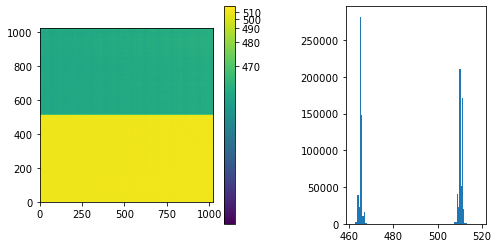

In [19]:
imgandhist(master_darks[-1])

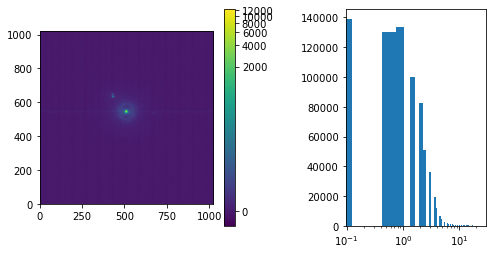

In [21]:
imgandhist(np.nanmedian(fits_stack[0:10], axis=0), log=True)

In [ ]:
# TODO: split multichannel Ha /off images into separate cubes
# center (centroid? circlesym?)

